## Feature Scaling and Normalization - Lab

## Introduction
In this lab, you'll practice your feature scaling and normalization skills!

## Objectives
You will be able to:
* Implement min-max scaling, mean-normalization, log normalization and unit vector normalization in python
* Identify appropriate normalization and scaling techniques for a given dataset

## Back to our Boston Housing data

Let's import our Boston Housing data. Remember we categorized two variables and deleted the "NOX" (nitride oxide concentration) variable because it was highly correlated with two other features.

In [1]:
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)

# first, create bins for RAD based on the values observed. 5 values will result in 4 bins
bins = [0, 3, 4 , 5, 24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# first, create bins for TAX based on the values observed. 6 values will result in 5 bins
bins = [0, 250, 300, 360, 460, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

tax_dummy = pd.get_dummies(bins_tax, prefix="TAX", drop_first=True)
rad_dummy = pd.get_dummies(bins_rad, prefix="RAD", drop_first=True)
boston_features = boston_features.drop(["RAD","TAX"], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)
boston_features = boston_features.drop("NOX",axis=1)

## Look at the histograms for the continuous variables

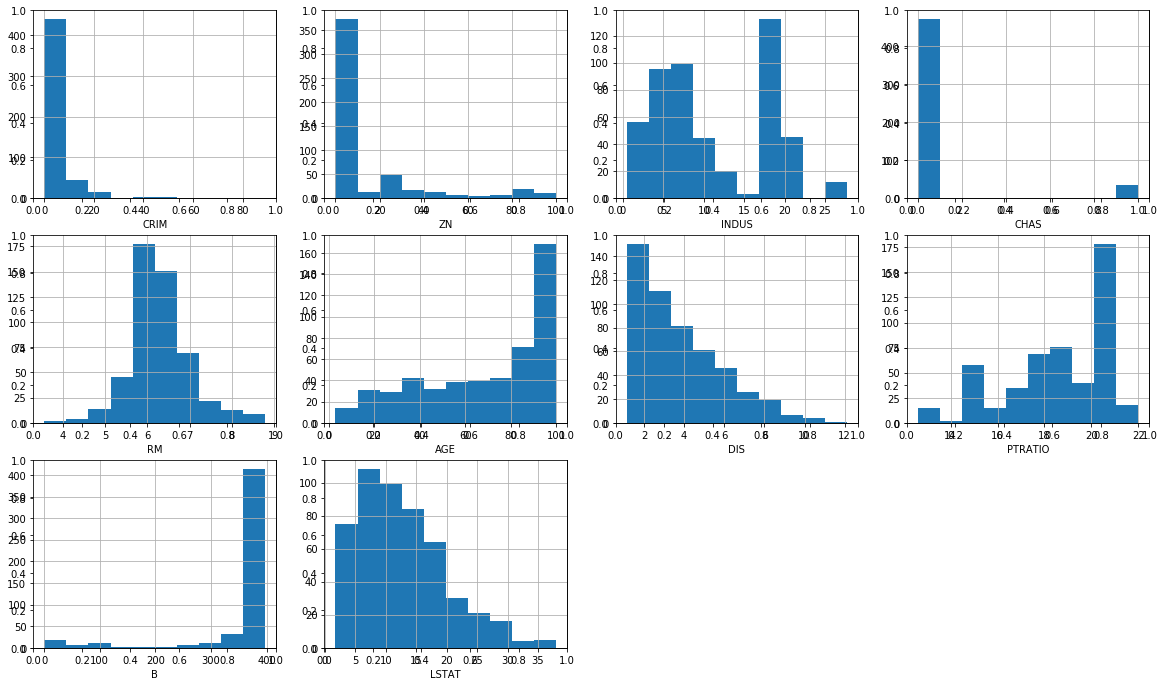

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def histograms(df, exclude):
    r_w = 20
    r_h = 4
    c_n = 4
    r_n = len(df.columns)/c_n
    r_n = int(r_n) + (1 if r_n % int(r_n) != 0 else 0)

    fig = plt.figure(figsize=(r_w, r_h*r_n))

    axes = fig.subplots(r_n, c_n)
    unused = list(range(0, len(axes.flatten())))

    included_vars = []
    for index, variable in enumerate(df.columns):
        if variable[0:3] not in exclude:
            ax = fig.add_subplot(r_n, c_n, index+1)
            df[variable].hist(ax=ax)
            plt.xlabel(variable)
            included_vars.append(variable)
            unused.remove(index)

    flattened_axes = axes.flatten()
    for u in unused:
        fig.delaxes(flattened_axes[u])

    return included_vars

exclude_vars = ['RAD', 'TAX']
continuous_vars = histograms(boston_features, exclude_vars)

## Perform log transformations for the variables where it makes sense

Analyze the results in terms of how they improved the normality performance. What is the problem with the "ZN" variable?  

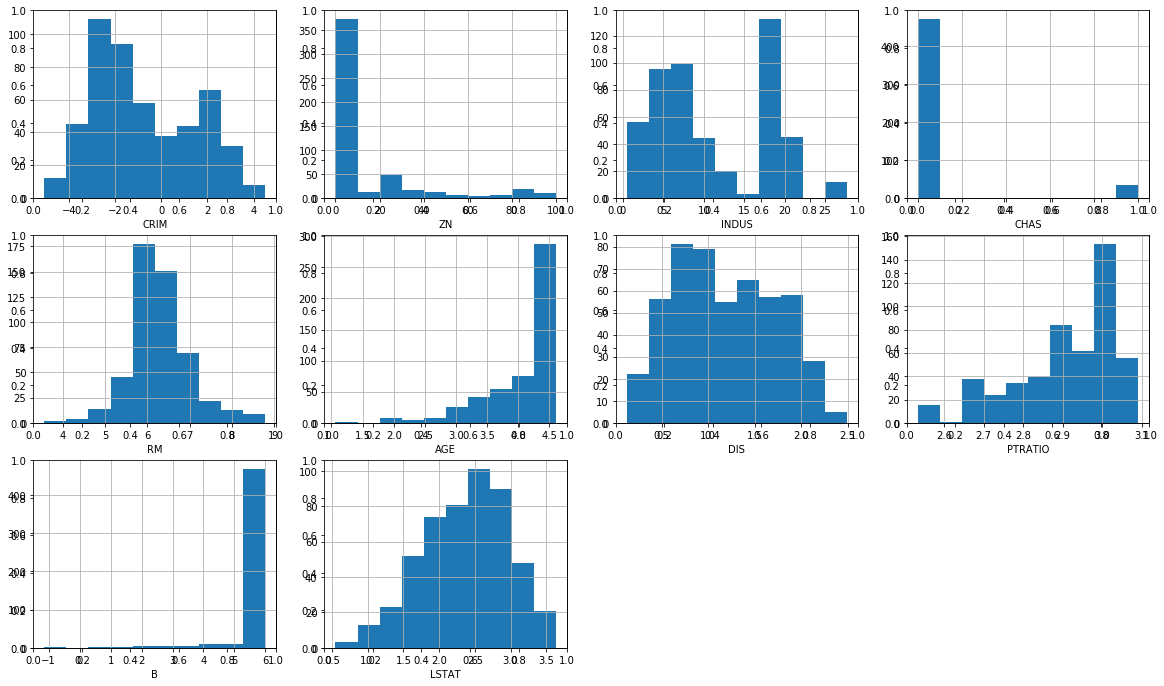

In [3]:
# Your code here
import numpy as np

def log_transform(df, non_normal, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in non_normal:
        df[feat] = df[feat].map(lambda x: np.log(x))
    return df

non_normal = ['CRIM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']
histograms(log_transform(boston_features, non_normal), exclude_vars);

"ZN" has a lot of zeros (more than 50%!). Remember that this variable denoted: "proportion of residential land zoned for lots over 25,000 sq.ft.". It might have made sense to categorize this variable to "over 25,000 feet or not (binary variable 1/0). Now you have a zero-inflated variable which is cumbersome to work with.

In [4]:
# Your code here

# Log-transformation Impact:
#   1. CRIM: big difference; it is now more normally distributed
#   2. AGE: undesirable result: log transformation skewed this even more to the right
#   3. DIS: HUGE difference; it is now more normally distributed
#   4. PTRATIO: undesirable result: log transformation did not normalize the distribution... must change it back
#   5. B: undesirable result: log transformation skewed this even more to the right
#   6. LSTAT: it is now more normally distributed

# Key takeaway: only ['CRIM', 'DIS', 'LSTAT'] log-transformations should be committed to our operating data set
non_normal = ['CRIM', 'DIS', 'LSTAT']

# let's do a quick regression analysis before we commit the log-transformations

target = 'MEDV'

# we need the target
boston_target = pd.DataFrame(data=boston.target, columns=[target])
#print(boston_target, "\n")
boston_features = pd.concat([boston_features, boston_target], axis=1, join='inner')
#print(boston_features.head(), "\n")

exclude_vars.append(target[0:3])

from statsmodels.formula.api import ols

predictors = '+'.join(non_normal)
f = target + '~' + predictors
model = ols(formula=f, data=boston_features)
model_fit_results = model.fit()
model_fit_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     221.6
Date:                Sun, 20 Oct 2019   Prob (F-statistic):           1.52e-91
Time:                        20:26:38   Log-Likelihood:                -1626.8
No. Observations:                 506   AIC:                             3262.
Df Residuals:                     502   BIC:                             3279.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.5232      0.998     38.616      0.000      36.563      40.483
CRIM          -0.1067      0.036     -2.974      0.003      -0.177      -0.036
DIS           -0.7655      0.150     -5.092      0.000      -1.061      -0.470
LSTAT         -1.0037      0.046    -21.786      0.000      -1.094      -0.913
==============================================================================
Omnibus:                      121.452   Durbin-Watson:                   0.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.803
Skew:                           1.347   Prob(JB):                     2.80e-51
Kurtosis:                       4.947   Cond. No.                         59.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
import statsmodels.stats.api as sms
#name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
jbtest = sms.jarque_bera(model_fit_results.resid)
results = [[
    predictors
    , model_fit_results.rsquared
    , model_fit_results.params[0]   # intercept
    , model_fit_results.params[1]   # slope
    , model_fit_results.pvalues[1]  # p-value for indep
    , jbtest[0]
]]
pd.DataFrame(results, columns=['Independent Variable', 'R-squared', 'Intercept', 'Slope', 'P-value', 'Normality (JB)'])

,Independent Variable,R-squared,Intercept,Slope,P-value,Normality (JB)
0,CRIM+DIS+LSTAT,0.569807,38.523184,-0.106687,0.003083,232.802996


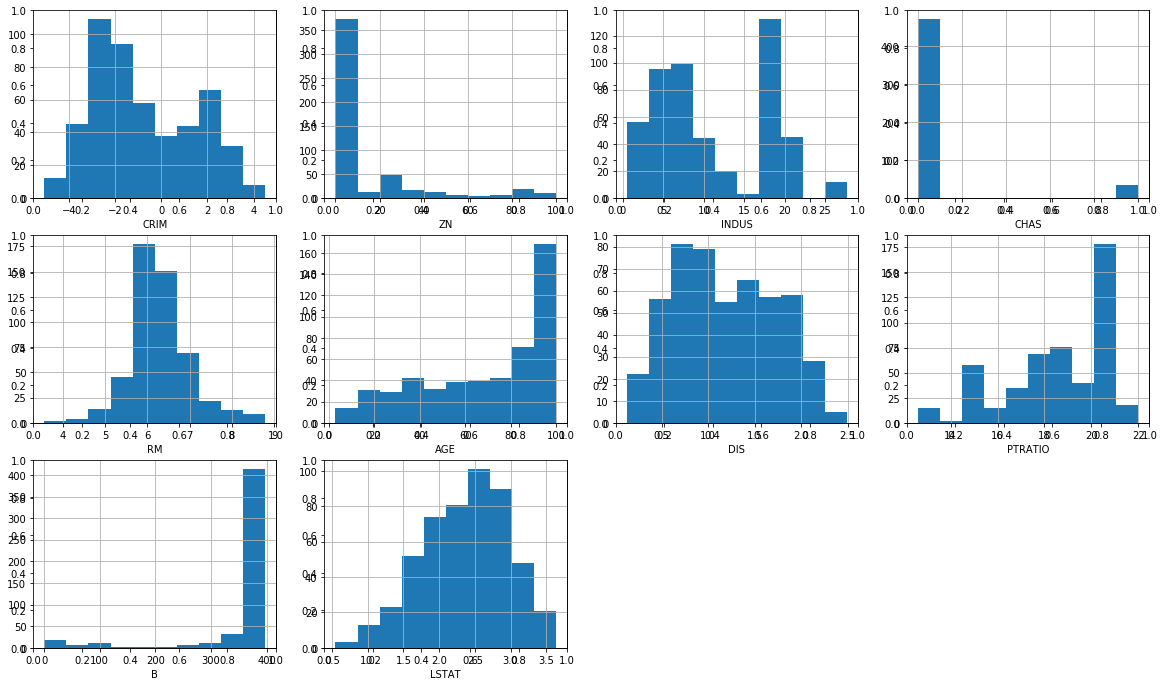

In [6]:
# now let's commit the log transformations
boston_features = log_transform(boston_features, non_normal)
histograms(boston_features, exclude_vars);

In [7]:
# let's do another regression analysis to see where we're at after the above log-transformation
model = ols(formula=f, data=boston_features)
model_fit_results = model.fit()
model_fit_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     385.4
Date:                Sun, 20 Oct 2019   Prob (F-statistic):          8.33e-130
Time:                        20:26:44   Log-Likelihood:                -1537.9
No. Observations:                 506   AIC:                             3084.
Df Residuals:                     502   BIC:                             3101.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.2762      1.460     40.606      0.000      56.408      62.144
CRIM          -0.5732      0.167     -3.429      0.001      -0.902      -0.245
DIS           -4.5535      0.634     -7.180      0.000      -5.799      -3.308
LSTAT        -13.4042      0.472    -28.395      0.000     -14.332     -12.477
==============================================================================
Omnibus:                       86.726   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.487
Skew:                           0.933   Prob(JB):                     3.90e-40
Kurtosis:                       5.264   Cond. No.                         21.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
jbtest = sms.jarque_bera(model_fit_results.resid)
results.append([
    predictors
    , model_fit_results.rsquared
    , model_fit_results.params[0]   # intercept
    , model_fit_results.params[1]   # slope
    , model_fit_results.pvalues[1]  # p-value for indep
    , jbtest[0]
])
pd.DataFrame(results, columns=['Independent Variable', 'R-squared', 'Intercept', 'Slope', 'P-value', 'Normality (JB)'])

,Independent Variable,R-squared,Intercept,Slope,P-value,Normality (JB)
0,CRIM+DIS+LSTAT,0.569807,38.523184,-0.106687,0.003083,232.802996
1,CRIM+DIS+LSTAT,0.697267,59.276167,-0.573230,0.000656,181.486608


## Try different types of transformations on the continuous variables

Store your final features in a dataframe `features_final`

In [9]:
# Your code here

# Min-max scaling: this will not be particularly useful to us in this case since this way of scaling brings values between 0 and 1
def min_max_scaling(df, non_normal, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in non_normal:
        min_feat = df[feat].min()
        max_feat = df[feat].max()
        df[feat] = df[feat].map(lambda x: (x-min_feat)/(max_feat-min_feat))
    return df

# standardization does not make data  moremore  normal, it will just change the mean and the standard error!
def standardization(df, vars, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in non_normal:
        mean_feat = df[feat].mean()
        sqr_var_feat = np.sqrt(np.var(df[feat]))
        df[feat] = df[feat].map(lambda x: (x-mean_feat)/sqr_var_feat)
    return df

# The distribution will have values between -1 and 1, and a mean of 0.
def mean_normalization(df, vars, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in non_normal:
        mean_feat = df[feat].mean()
        min_feat = df[feat].min()
        max_feat = df[feat].max()
        df[feat] = df[feat].map(lambda x: (x-mean_feat)/(max_feat-min_feat))
    return df    

# Unit vector transformation
def unit_vector_normalization(df, vars, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in non_normal:
        norm_feat = np.sqrt((df[feat]**2).sum())
        df[feat] = df[feat].map(lambda x: x/norm_feat)
    return df 

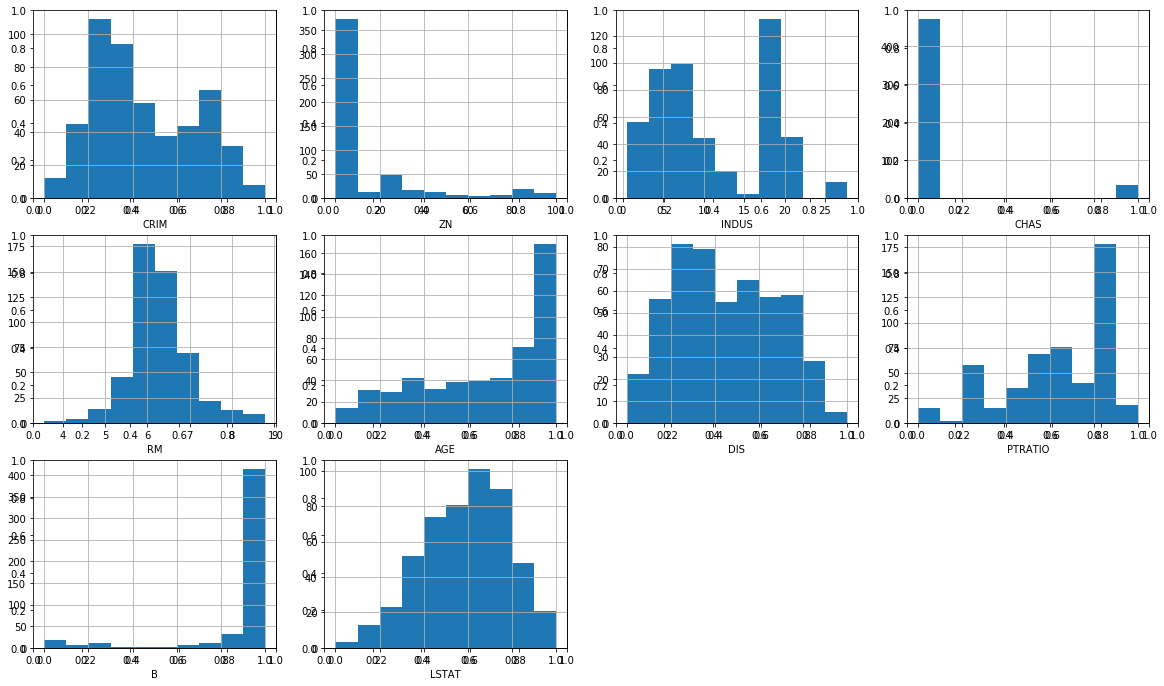

In [10]:
non_normal = ['CRIM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']
histograms(min_max_scaling(boston_features, non_normal), exclude_vars);

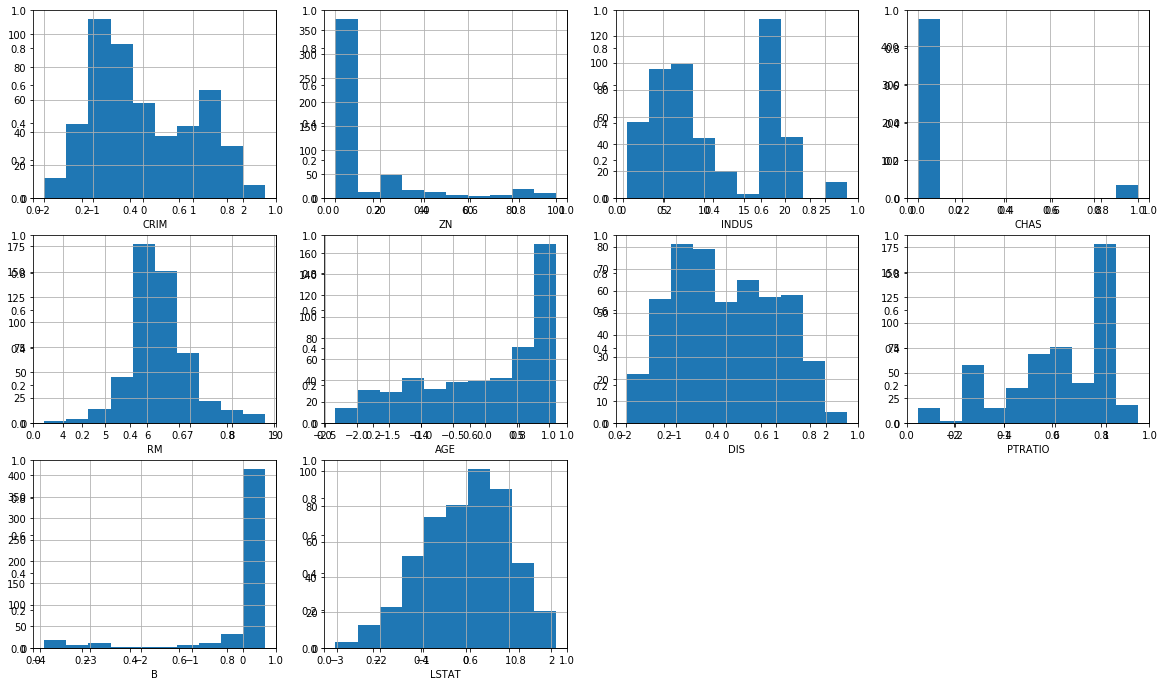

In [11]:
histograms(standardization(boston_features, non_normal), exclude_vars);

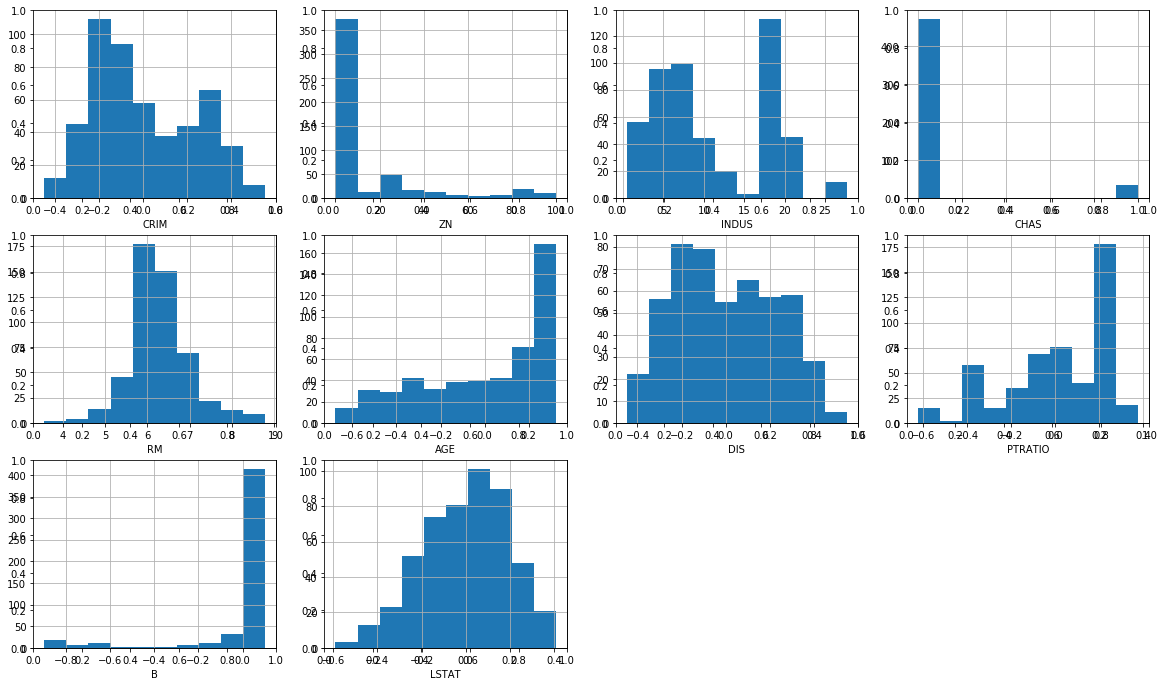

In [12]:
histograms(mean_normalization(boston_features, non_normal), exclude_vars);

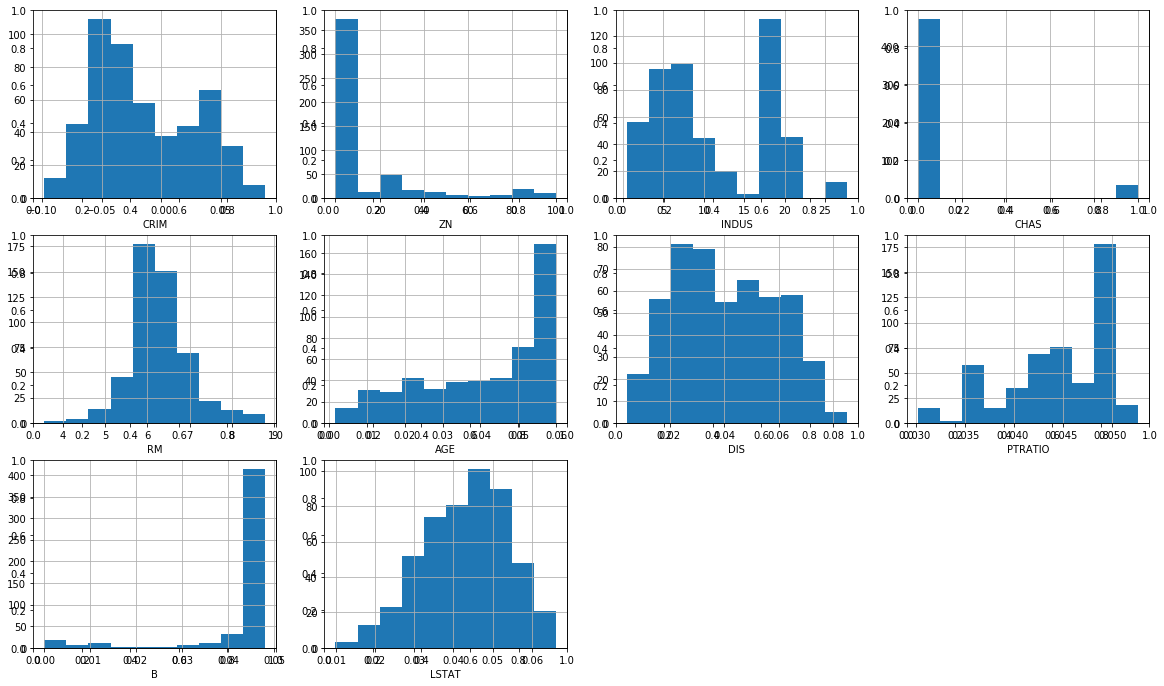

In [13]:
histograms(unit_vector_normalization(boston_features, non_normal), exclude_vars);

## Summary
Great! You've now transformed your final data using feature scaling and normalization, and stored them in the `features_final` dataframe.